### Aim: 
In this notebook, the effect of adding ToxCast variables to current best-in-class logistic regression based model (Chen M et al., 2016 aso referred to as FDA's model within this notebooks' series) for predicting mostDILI drugs will be evaluated.  <br>

Logistic regression is the algorithm used by Chen M et al., 2016 and hence forms a good basis for evaluating effect of new variables to the existing model (for most DILI classification).  Subsequently, other alternative algorithms will also be evaluated in separate notebooks for classification performance.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn') 

%matplotlib inline

import pandas_profiling

In [34]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read-in datasets

All datasets have been previously treated for missing values and dummy coding of categorical variables(reactive_metabolites, classificn, and ~216 toxcast targets).

Output/target/Y variable for modeling purposes is "classificn" (1="mostDILI", 0 = "other" which includes lessDILI/ambiDILI/noDILI)

In [35]:
mc = pd.read_csv("mc_scaled_labeled.csv")
tc = pd.read_csv("tc_pca_labeled.csv")
mc_tc=pd.read_csv("mctc_pca_labeled.csv")

In [36]:
mc.head()
mc.isnull().sum()#no null values in dataframe

,chnm,cmax,mol_wt,dailydose,logP,reactive_metabolites,classificn
0,abacavir,-0.246513,-0.411151,0.040093,-0.459470,1.017292,1
1,acetaminophen,0.997393,-1.359063,2.832049,-0.791490,1.017292,1
2,acitretin,-0.390792,-0.129961,-0.617180,1.873645,-0.983002,1
3,albendazole,-0.394776,-0.558426,-0.192570,0.213544,1.017292,1
4,alclofenac,5.952769,-0.829645,0.796248,0.294306,1.017292,1


chnm                    0
cmax                    0
mol_wt                  0
dailydose               0
logP                    0
reactive_metabolites    0
classificn              0
dtype: int64

In [37]:
tc.head()
tc.isnull().sum().T# no null values in dataframe

,chnm,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P20,P21,P22,P23,P24,P25,P26,P27,P28,classificn
0,abacavir,-1.453781,-0.645957,-0.042387,-0.613409,-0.383872,0.003563,-0.036099,-0.166559,-0.251330,...,0.332493,-0.384955,-0.103455,0.874200,-0.643686,0.654882,0.699779,0.421477,-0.002905,1
1,acetaminophen,-0.280884,0.297014,1.704332,0.586057,0.406694,0.340701,1.252860,-0.431265,2.469549,...,-0.813639,0.222896,-0.263584,-1.537387,-1.949884,0.636464,-1.337835,-0.075963,-1.225050,1
2,acitretin,-1.116905,-0.588255,-0.067545,-0.455004,-0.432180,0.553050,0.050969,-0.027998,-0.295202,...,-0.236979,0.399888,0.569811,0.595930,0.550770,-0.300266,0.560164,-0.338131,-0.234198,1
3,albendazole,-0.582517,1.004084,-1.160341,-0.468495,-0.503714,0.647676,-0.436439,0.350573,-0.063671,...,-1.409748,0.513968,0.543193,0.153357,2.287368,0.156084,1.410520,-0.504880,-0.437613,1
4,alclofenac,-1.401812,-0.811473,0.041537,-0.372151,-0.318848,0.315268,0.085781,-0.082962,-0.227885,...,0.207117,-0.221817,0.090859,0.541376,-0.275087,-0.236340,0.056372,0.188017,0.006071,1


chnm          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
classificn    0
dtype: int64

In [38]:
mc_tc.head()
mc_tc.isnull().sum()#no null values in dataframe

,chnm,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,classificn
0,abacavir,-1.444762,-0.649513,-0.062304,-0.644003,-0.315813,0.012594,-0.065045,-0.231388,-0.150218,...,0.123063,1.036630,0.139326,0.812508,0.420413,0.753550,-0.256332,0.046677,-0.172548,1
1,acetaminophen,-0.309496,0.169900,1.727844,0.772510,0.539620,0.242570,1.063954,0.103382,2.772589,...,-0.390303,0.080579,2.855425,0.421643,-1.936300,0.543964,-1.354443,-0.605531,1.300690,1
2,acitretin,-1.094369,-0.538019,-0.072097,-0.580733,-0.549017,0.599654,0.123163,0.000038,-0.445833,...,0.466004,0.560191,-0.549604,-0.431520,0.592038,-0.583815,-0.571781,0.117369,-0.187685,1
3,albendazole,-0.558443,1.035149,-1.156281,-0.551930,-0.480370,0.652524,-0.503921,0.271689,-0.043037,...,0.037598,-0.110890,-1.228410,1.093255,1.857060,-0.180542,-0.610346,-0.250679,0.792903,1
4,alclofenac,-1.414305,-0.912262,0.019345,-0.169191,-0.357133,-0.014595,-0.369297,0.662525,0.078874,...,0.457491,1.342014,0.192954,-0.250706,0.105768,0.190462,-0.563103,-0.608185,0.379748,1


chnm          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
classificn    0
dtype: int64

### Exploratory data analysis (EDA)

EDA will be done on two datasets: <br>
a) mc_scaled (to visualize correlations between Minjun Chen's variables with classification) and <br>
b) mc_tc dataframe (to visualize correlation of "all" variables - Minjun's variables and ToxCast variables with classification).  

Because EDA of mc_tc data frame will also include variables present in tc dataframe, no additional EDA will be performed explicitly on tc dataframe

In [39]:
# EDA using pandas profiling on mc (Minjun Chen variables)    
report = pandas_profiling.ProfileReport(mc)

#convert profile report as html file
report.to_file("mc.html")   
    #some variables - as published (Chen M et al., 2016 Hepatol) - have stronger correlations with classification of 1 (eg: reactive metabolites, Cmax, logP)
    #relationship of Cmax is stronger than than of daily dose; negative relationship between MW and classification of 1

In [40]:
# EDA using pandas_profiling on mc_tc (Minjun Chen variables + ToxCast variables)
report = pandas_profiling.ProfileReport(mc_tc)

#convert profile report as html file
report.to_file("mc_tc.html")   #some of the principal components have significant correlations with "classification"

### Data preparation for ML

Step1: Assemble dataframes "x" (contains all predictors) and "y" from each of the datasets to be used for modeling: mc, tc, mc_tc

In [41]:
#Create "x" consisting of all independent variables from each of the dataframes (mc, tc, mc_tc) to be used for modeling

mc_num=mc.select_dtypes(include=[np.number])
x_mc=mc_num.drop(["classificn"], axis=1)

tc_num=tc.select_dtypes(include=[np.number])
x_tc=tc_num.drop(["classificn"], axis=1)

mc_tc_num=mc_tc.select_dtypes(include=[np.number])
x_mc_tc=mc_tc_num.drop(["classificn"], axis=1)

In [42]:
#create "y" consisting of outcome/target variable from each of the dataframes (mc, tc, mc_tc) to be used for modeling

y_mc=mc_num["classificn"] 
y_tc=tc_num["classificn"]
y_mc_tc=mc_tc_num["classificn"]

#check to make sure all datasets are equivalent for classification column
y_mc.equals(y_tc)
y_mc.equals(y_mc_tc)
y_tc.equals(y_mc_tc)

#breakdown of mostDILI drugs vs other drugs
y_mc.value_counts()#60 drugs are labeled as "mostDILI" and 115 drugs as "other"

True

True

True

0    115
1     60
Name: classificn, dtype: int64

Step2: Create test/train split of data

In [43]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [44]:
## test train stratified split at 40:60 ratio (maintains ratio of mostDILI drugs:other drugs)
# allows for testing on 24 "mostDILI" and training on 36 "mostDILI" drugs
train_mcx, test_mcx, train_mcy, test_mcy = train_test_split(x_mc,y_mc, stratify=y_mc, test_size=0.4, random_state=123)

train_tcx, test_tcx, train_tcy, test_tcy = train_test_split(x_tc,y_tc, stratify=y_tc, test_size=0.4, random_state=123)

train_mctcx, test_mctcx, train_mctcy, test_mctcy = train_test_split(x_mc_tc,y_mc_tc, stratify=y_mc_tc, test_size=0.4, random_state=123)

#confirm that test datasets are same across all splits
test_mctcy.equals(test_tcy)
test_mcy.equals(test_tcy)

True

True

### Logistic regression modeling

With an aim to determine, what value - if any, do variables derived from Toxcast targets/pathways, have on ability to model for "mostDILI" drugs, 3 instances of logistic regression will be created for modeling against each dataset (i.e., without test/train split).

10-fold cross validation will be carried out and the accuracy +/- standard deviation determined for each model.

Subsequently, each dataset will also be partitioned via test-train split (stratified sampling) and evaluated via ROC curves against each other.  Models may be refined further via tweaking of thresholds to increase sensitivity.

In [45]:
### Instantiate logistic regression model
from sklearn.linear_model import LogisticRegression

log_mc=LogisticRegression(class_weight='balanced')
log_tc=LogisticRegression(class_weight='balanced')
log_mctc=LogisticRegression(class_weight='balanced')

#### Performance of models using 3-fold cross-validation

In [46]:
from sklearn.model_selection import cross_val_score

log_accuracy_scores_mc = cross_val_score(log_mc, x_mc, y_mc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on logistic regression using mc (Chen M et al., 2016 Hepatol) variables")
print(log_accuracy_scores_mc)
print("Accuracy mean: " +str(log_accuracy_scores_mc.mean()), "Accuracy standard deviation: " + str(log_accuracy_scores_mc.std()))
print("")

log_accuracy_scores_tc = cross_val_score(log_tc, x_tc, y_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on logistic regression using tc (ToxCast targets/pathways) variables")
print(log_accuracy_scores_tc)
print("Accuracy mean: " +str(log_accuracy_scores_tc.mean()), "Accuracy standard deviation: " + str(log_accuracy_scores_tc.std()))
print("")

log_accuracy_scores_mctc = cross_val_score(log_mctc, x_mc_tc, y_mc_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on logistic regression using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables")
print(log_accuracy_scores_mctc)
print("Accuracy mean: " +str(log_accuracy_scores_mctc.mean()), "Accuracy standard deviation: " + str(log_accuracy_scores_mctc.std()))

Accuracy: 3-fold cross validation scores on logistic regression using mc (Chen M et al., 2016 Hepatol) variables
[0.54237288 0.5862069  0.63793103]
Accuracy mean: 0.5888369374634717 Accuracy standard deviation: 0.03905575496347585

Accuracy: 3-fold cross validation scores on logistic regression using tc (ToxCast targets/pathways) variables
[0.69491525 0.48275862 0.62068966]
Accuracy mean: 0.599454510033119 Accuracy standard deviation: 0.08790452332457582

Accuracy: 3-fold cross validation scores on logistic regression using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables
[0.61016949 0.67241379 0.68965517]
Accuracy mean: 0.6574128190142218 Accuracy standard deviation: 0.03413956926394119


In [47]:
log_mc_acc_ul=log_accuracy_scores_mc.mean()+log_accuracy_scores_mc.std()
log_mc_acc_ll=log_accuracy_scores_mc.mean()-log_accuracy_scores_mc.std()

log_mctc_acc_ul=log_accuracy_scores_mctc.mean()+log_accuracy_scores_mctc.std()
log_mctc_acc_ll=log_accuracy_scores_mctc.mean()-log_accuracy_scores_mctc.std()

log_mc_acc_ul, log_mc_acc_ll, log_mctc_acc_ul, log_mctc_acc_ll

(0.6278926924269475, 0.5497811824999959, 0.691552388278163, 0.6232732497502805)

Conclusion: borderline improvement in model accuracy by addition of toxcast variables. However, there may still be an effect on other performance characteristics such as precision/recall.

#### Fit logistic regression models using test-train split

In [48]:
###fit logistic regression model 
log_mc.fit(train_mcx, train_mcy)
log_tc.fit(train_tcx, train_tcy)
log_mctc.fit(train_mctcx, train_mctcy)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#### Predict using models fitted on test-train splits

In [49]:
### Using logistic regression model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
log_pred_mcy=log_mc.predict(test_mcx) 
log_probs_mcy=log_mc.predict_proba(test_mcx) 

### Using logistic regression model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
log_pred_tcy=log_tc.predict(test_tcx) 
log_probs_tcy=log_tc.predict_proba(test_tcx) 


### Using logistic regression model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
log_pred_mctcy=log_mctc.predict(test_mctcx) 
log_probs_mctcy=log_mctc.predict_proba(test_mctcx) 
   

#### Performance metrics of models fitted on test-train splits

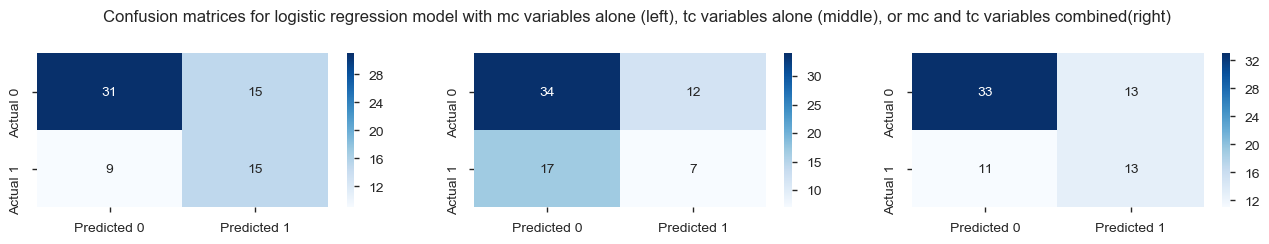

In [50]:
### Confusion Matrix
log_cfm_mc=metrics.confusion_matrix(test_mcy, log_pred_mcy)
log_cfm_tc=metrics.confusion_matrix(test_tcy, log_pred_tcy)
log_cfm_mctc=metrics.confusion_matrix(test_mctcy, log_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(log_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(log_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(log_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for logistic regression model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);


In [51]:
### Precision, Recall
log_cr_mc=metrics.classification_report(test_mcy, log_pred_mcy)
log_cr_tc=metrics.classification_report(test_tcy, log_pred_tcy)
log_cr_mctc=metrics.classification_report(test_mctcy, log_pred_mctcy)

print("precision_recall for model with mc variables alone")
print(log_cr_mc)

print("precision_recall for model with tc variables alone")
print(log_cr_tc)

print("precision_recall for model with mc&tc variables combined")
print(log_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.78      0.67      0.72        46
          1       0.50      0.62      0.56        24

avg / total       0.68      0.66      0.66        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.67      0.74      0.70        46
          1       0.37      0.29      0.33        24

avg / total       0.56      0.59      0.57        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.75      0.72      0.73        46
          1       0.50      0.54      0.52        24

avg / total       0.66      0.66      0.66        70



In [52]:
### Accuracy
log_acc_mc=round(metrics.accuracy_score(test_mcy, log_pred_mcy), 2)
print("Overall accuracy with mc dataset @ default threshold: " + str(log_acc_mc)+"\n")

log_acc_tc=round(metrics.accuracy_score(test_mcy, log_pred_tcy), 2)
print("Overall accuracy with tc dataset @ default threshold: " + str(log_acc_tc)+"\n")

log_acc_mctc=round(metrics.accuracy_score(test_mctcy, log_pred_mctcy), 2)
print("Overall accuracy with mctc dataset @ default threshold: " + str(log_acc_mctc)+"\n")

Overall accuracy with mc dataset @ default threshold: 0.66

Overall accuracy with tc dataset @ default threshold: 0.59

Overall accuracy with mctc dataset @ default threshold: 0.66



In [53]:
###Specificity
from sklearn.metrics import confusion_matrix

tn_mc, fp_mc, fn_mc, tp_mc = confusion_matrix(test_mcy, log_pred_mcy).ravel()
specificity_mc = tn_mc / (tn_mc+fp_mc)
print("Specificity for model with mc variables alone")
round(specificity_mc,3)

tn_tc, fp_tc, fn_tc, tp_tc = confusion_matrix(test_tcy, log_pred_tcy).ravel()
specificity_tc = tn_tc / (tn_tc+fp_tc)
print("Specificity for model with tc variables alone")
round(specificity_tc,3)

tn_mctc, fp_mctc, fn_mctc, tp_mctc = confusion_matrix(test_mctcy, log_pred_mctcy).ravel()
specificity_mctc = tn_mctc / (tn_mctc+fp_mctc)
print("specificity for model with mctc variables")
round(specificity_mctc, 3)

Specificity for model with mc variables alone


0.674

Specificity for model with tc variables alone


0.739

specificity for model with mctc variables


0.717

In [54]:
#calculate values to populate ROC curve
from sklearn.metrics import roc_curve

log_fpr_mc,log_tpr_mc, log_thresholds_mc=roc_curve(test_mcy, log_probs_mcy[:, 1])
log_roc_auc_mc=metrics.auc(log_fpr_mc, log_tpr_mc)

log_fpr_tc,log_tpr_tc, log_thresholds_tc=roc_curve(test_tcy, log_probs_tcy[:, 1])
log_roc_auc_tc=metrics.auc(log_fpr_tc, log_tpr_tc)

log_fpr_mctc,log_tpr_mctc, log_thresholds_mctc=roc_curve(test_mctcy, log_probs_mctcy[:, 1])
log_roc_auc_mctc=metrics.auc(log_fpr_mctc, log_tpr_mctc)

#Calculate values to populate precision-recall curve
from sklearn.metrics import precision_recall_curve

log_precision_mc, log_recall_mc, log_thresholds_mc = precision_recall_curve(test_mcy, log_probs_mcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
log_pr_auc_mc = metrics.auc(log_recall_mc, log_precision_mc)

log_precision_tc, log_recall_tc, log_thresholds_tc = precision_recall_curve(test_tcy, log_probs_tcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
log_pr_auc_tc = metrics.auc(log_recall_tc, log_precision_tc)

log_precision_mctc, log_recall_mctc, log_thresholds_mctc = precision_recall_curve(test_mctcy, log_probs_mctcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
log_pr_auc_mctc = metrics.auc(log_recall_mctc, log_precision_mctc)


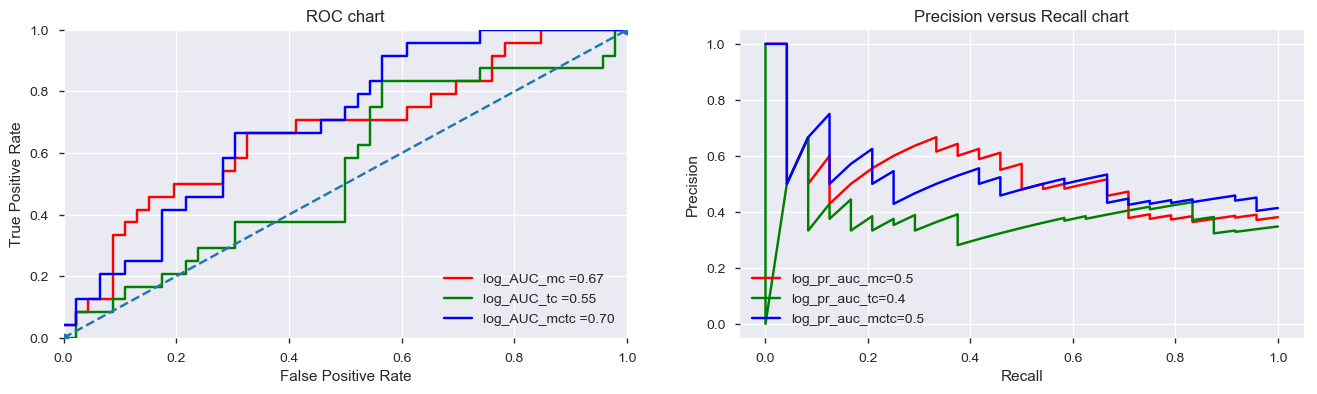

In [55]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("ROC chart")
plt.plot(log_fpr_mc, log_tpr_mc, 'r', label='log_AUC_mc =%0.2f'% log_roc_auc_mc)
plt.plot(log_fpr_tc, log_tpr_tc, 'g', label='log_AUC_tc =%0.2f'% log_roc_auc_tc)
plt.plot(log_fpr_mctc, log_tpr_mctc, 'b', label='log_AUC_mctc =%0.2f'% log_roc_auc_mctc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")


axes = fig.add_subplot(122)
plt.title("Precision versus Recall chart")
plt.plot(log_recall_mc, log_precision_mc, "r", label = 'log_pr_auc_mc=%.1f' % (log_pr_auc_mc))
plt.plot(log_recall_tc, log_precision_tc, "g", label = 'log_pr_auc_tc=%.1f' % (log_pr_auc_tc))
plt.plot(log_recall_mctc, log_precision_mctc, "b", label = 'log_pr_auc_mctc=%.1f' % (log_pr_auc_mctc))
plt.legend(loc='lower left')
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.show();

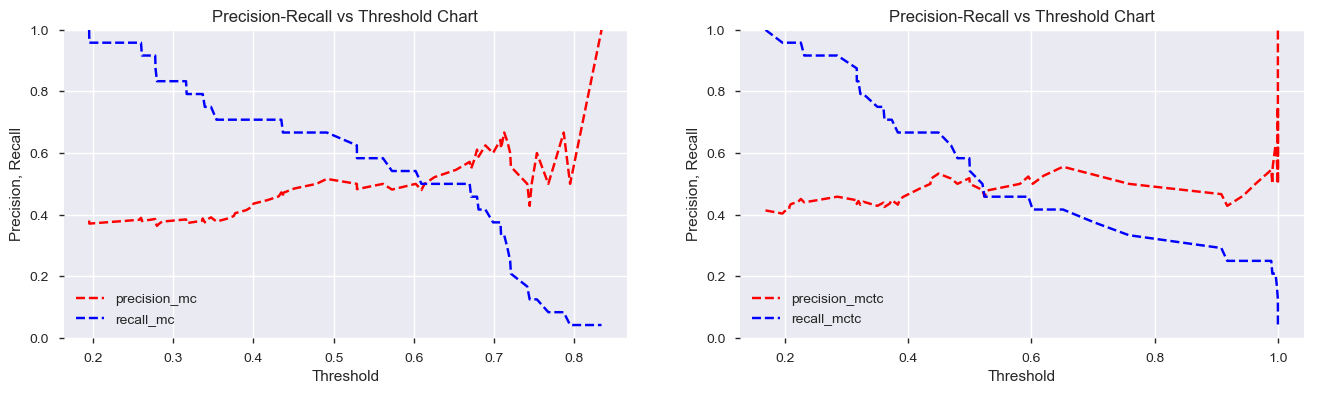

In [56]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(log_thresholds_mc, log_precision_mc[: -1], "r--", label="precision_mc")
plt.plot(log_thresholds_mc, log_recall_mc[: -1], "b--", label="recall_mc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


axes = fig.add_subplot(122)
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(log_thresholds_mctc, log_precision_mctc[: -1], "r--", label="precision_mctc")
plt.plot(log_thresholds_mctc, log_recall_mctc[: -1], "b--", label="recall_mctc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


plt.show();

#### Adjust thresholds manually and re-evaluate metrics
Note: Default threshold (for classification = 1 i.e., "mostDILI" drug) is P>0.5. In below section, threshold is weakedt to <0.5 for enhancing model performance w.r.t. sensitivity and model metrics re-calculated

**Threshold>0.45**

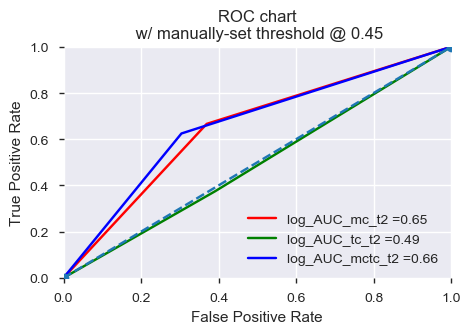

In [57]:
 #Adjust threshold for each of the models
log_pred_mcy_t2=(log_mc.predict_proba(test_mcx) [:, 1]>=0.45).astype(bool)

log_pred_tcy_t2=(log_tc.predict_proba(test_tcx) [:, 1]>=0.45).astype(bool)

log_pred_mctcy_t2=(log_mctc.predict_proba(test_mctcx) [:, 1]>=0.45).astype(bool)

#plot ROC curve based on adjusted thresholds )using predicitons instead of probabilities)

log_fpr_mc_t2,log_tpr_mc_t2, log_thresholds_mc_t2=roc_curve(test_mcy, log_pred_mcy_t2)
log_roc_auc_mc_t2=metrics.auc(log_fpr_mc_t2, log_tpr_mc_t2)

log_fpr_tc_t2,log_tpr_tc_t2, log_thresholds_tc_t2=roc_curve(test_tcy, log_pred_tcy_t2)
log_roc_auc_tc_t2=metrics.auc(log_fpr_tc_t2, log_tpr_tc_t2)

log_fpr_mctc_t2,log_tpr_mctc_t2, log_thresholds_mctc_t2=roc_curve(test_mctcy, log_pred_mctcy_t2)
log_roc_auc_mctc_t2=metrics.auc(log_fpr_mctc_t2, log_tpr_mctc_t2)

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(5)

plt.title("ROC chart\n w/ manually-set threshold @ 0.45")
plt.plot(log_fpr_mc_t2, log_tpr_mc_t2, 'r', label='log_AUC_mc_t2 =%0.2f'% log_roc_auc_mc_t2)
plt.plot(log_fpr_tc_t2, log_tpr_tc_t2, 'g', label='log_AUC_tc_t2 =%0.2f'% log_roc_auc_tc_t2)
plt.plot(log_fpr_mctc_t2, log_tpr_mctc_t2, 'b', label='log_AUC_mctc_t2 =%0.2f'% log_roc_auc_mctc_t2)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show();   

In [58]:
### Accuracy, Precision, Recall with modified threshold (t2)
log_acc_mc_t2=round(metrics.accuracy_score(test_mcy, log_pred_mcy_t2), 2)
print("Overall accuracy with mc dataset and modified threshold of P>=0.45: " + str(log_acc_mc_t2)+"\n")

log_cr_mc_t2=metrics.classification_report(test_mcy, log_pred_mcy_t2)
print("Classification report with mc dataset and modified threshold of P>=0.45: ")
print(log_cr_mc_t2)    
print("***************")


log_acc_tc_t2=round(metrics.accuracy_score(test_tcy, log_pred_tcy_t2), 2)
print("Overall accuracy with tc dataset and modified threshold of P>=0.45: " + str(log_acc_tc_t2)+"\n")

log_cr_tc_t2=metrics.classification_report(test_tcy, log_pred_tcy_t2)
print("Classification report with tc dataset and modified threshold of P>=0.45: ")
print(log_cr_tc_t2)   
print("***************")


log_acc_mctc_t2=round(metrics.accuracy_score(test_mctcy, log_pred_mctcy_t2), 2)
print("Overall accuracy with mctc dataset and modified threshold of P>=0.45: " + str(log_acc_mctc_t2)+"\n")

log_cr_mctc_t2=metrics.classification_report(test_mctcy, log_pred_mctcy_t2)
print("Classification report with mctc dataset and modified threshold of P>=0.45: ")
print(log_cr_mctc_t2) 

Overall accuracy with mc dataset and modified threshold of P>=0.45: 0.64

Classification report with mc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.78      0.63      0.70        46
          1       0.48      0.67      0.56        24

avg / total       0.68      0.64      0.65        70

***************
Overall accuracy with tc dataset and modified threshold of P>=0.45: 0.53

Classification report with tc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.65      0.61      0.63        46
          1       0.33      0.38      0.35        24

avg / total       0.54      0.53      0.53        70

***************
Overall accuracy with mctc dataset and modified threshold of P>=0.45: 0.67

Classification report with mctc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.78      0.70    

In [59]:
###Specificity with modified threshold (t2)
from sklearn.metrics import confusion_matrix

tn_mc_t2, fp_mc_t2, fn_mc_t2, tp_mc_t2 = confusion_matrix(test_mcy, log_pred_mcy_t2).ravel()
specificity_mc_t2 = tn_mc_t2 / (tn_mc_t2+fp_mc_t2)
print("Specificity for model with modified threshold of P>=0.45 and mc variables alone")
round(specificity_mc_t2,3)


tn_tc_t2, fp_tc_t2, fn_tc_t2, tp_tc_t2 = confusion_matrix(test_tcy, log_pred_tcy_t2).ravel()
specificity_tc_t2 = tn_tc_t2 / (tn_tc_t2+fp_tc_t2)
print("Specificity for model with modified threshold of P>=0.45 and tc variables alone")
round(specificity_tc_t2,3)

tn_mctc_t2, fp_mctc_t2, fn_mctc_t2, tp_mctc_t2 = confusion_matrix(test_mctcy, log_pred_mctcy_t2).ravel()
specificity_mctc_t2 = tn_mctc_t2 / (tn_mctc_t2+fp_mctc_t2)
print("specificity for model with modified threshold of P>=0.45 and mctc variables")
round(specificity_mctc_t2, 3)   

Specificity for model with modified threshold of P>=0.45 and mc variables alone


0.63

Specificity for model with modified threshold of P>=0.45 and tc variables alone


0.609

specificity for model with modified threshold of P>=0.45 and mctc variables


0.696

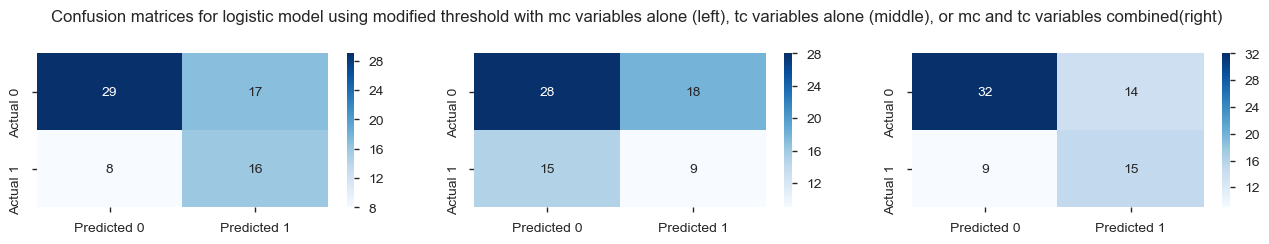

In [60]:
### Confusion Matrix with modified threshold (t2)
log_cfm_mc_t2=metrics.confusion_matrix(test_mcy, log_pred_mcy_t2)
log_cfm_tc_t2=metrics.confusion_matrix(test_tcy, log_pred_tcy_t2)
log_cfm_mctc_t2=metrics.confusion_matrix(test_mctcy, log_pred_mctcy_t2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(log_cfm_mc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(log_cfm_tc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(log_cfm_mctc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for logistic model using modified threshold with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

**Threshold>=0.43**

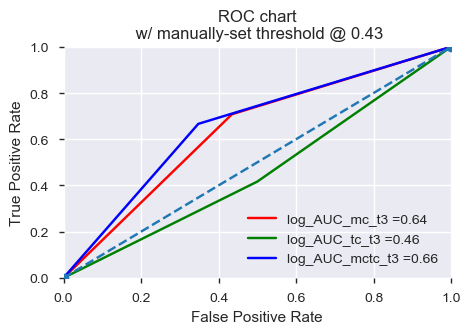

In [61]:
#Adjust threshold for each of the models
log_pred_mcy_t3=(log_mc.predict_proba(test_mcx) [:, 1]>=0.43).astype(bool)

log_pred_tcy_t3=(log_tc.predict_proba(test_tcx) [:, 1]>=0.43).astype(bool)

log_pred_mctcy_t3=(log_mctc.predict_proba(test_mctcx) [:, 1]>=0.43).astype(bool)

#plot ROC curve based on adjusted thresholds using predicitons instead of probabilities)

log_fpr_mc_t3,log_tpr_mc_t3, log_thresholds_mc_t3=roc_curve(test_mcy, log_pred_mcy_t3)
log_roc_auc_mc_t3=metrics.auc(log_fpr_mc_t3, log_tpr_mc_t3)

log_fpr_tc_t3,log_tpr_tc_t3, log_thresholds_tc_t3=roc_curve(test_tcy, log_pred_tcy_t3)
log_roc_auc_tc_t3=metrics.auc(log_fpr_tc_t3, log_tpr_tc_t3)

log_fpr_mctc_t3,log_tpr_mctc_t3, log_thresholds_mctc_t3=roc_curve(test_mctcy, log_pred_mctcy_t3)
log_roc_auc_mctc_t3=metrics.auc(log_fpr_mctc_t3, log_tpr_mctc_t3)

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(5)

plt.title("ROC chart\n w/ manually-set threshold @ 0.43")
plt.plot(log_fpr_mc_t3, log_tpr_mc_t3, 'r', label='log_AUC_mc_t3 =%0.2f'% log_roc_auc_mc_t3)
plt.plot(log_fpr_tc_t3, log_tpr_tc_t3, 'g', label='log_AUC_tc_t3 =%0.2f'% log_roc_auc_tc_t3)
plt.plot(log_fpr_mctc_t3, log_tpr_mctc_t3, 'b', label='log_AUC_mctc_t3 =%0.2f'% log_roc_auc_mctc_t3)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show();   

In [62]:
### Accuracy, Precision, Recall with modified threshold (t3)
log_acc_mc_t3=round(metrics.accuracy_score(test_mcy, log_pred_mcy_t3), 2)
print("Overall accuracy with mc dataset and modified threshold of P>=0.43: " + str(log_acc_mc_t3)+"\n")

log_cr_mc_t3=metrics.classification_report(test_mcy, log_pred_mcy_t3)
print("Classification report with mc dataset and modified threshold of P>=0.43: ")
print(log_cr_mc_t3)    
print("***************")


log_acc_tc_t3=round(metrics.accuracy_score(test_tcy, log_pred_tcy_t3), 2)
print("Overall accuracy with tc dataset and modified threshold of P>=0.43: " + str(log_acc_tc_t3)+"\n")

log_cr_tc_t3=metrics.classification_report(test_tcy, log_pred_tcy_t3)
print("Classification report with tc dataset and modified threshold of P>=0.43: ")
print(log_cr_tc_t3)   
print("***************")


log_acc_mctc_t3=round(metrics.accuracy_score(test_mctcy, log_pred_mctcy_t3), 2)
print("Overall accuracy with mctc dataset and modified threshold of P>=0.43: " + str(log_acc_mctc_t3)+"\n")

log_cr_mctc_t3=metrics.classification_report(test_mctcy, log_pred_mctcy_t3)
print("Classification report with mctc dataset and modified threshold of P>=0.43: ")
print(log_cr_mctc_t3) 

Overall accuracy with mc dataset and modified threshold of P>=0.43: 0.61

Classification report with mc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.79      0.57      0.66        46
          1       0.46      0.71      0.56        24

avg / total       0.68      0.61      0.62        70

***************
Overall accuracy with tc dataset and modified threshold of P>=0.43: 0.47

Classification report with tc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.62      0.50      0.55        46
          1       0.30      0.42      0.35        24

avg / total       0.51      0.47      0.48        70

***************
Overall accuracy with mctc dataset and modified threshold of P>=0.43: 0.66

Classification report with mctc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.79      0.65    

In [63]:
###Specificity with modified threshold (t3)
from sklearn.metrics import confusion_matrix

tn_mc_t3, fp_mc_t3, fn_mc_t3, tp_mc_t3 = confusion_matrix(test_mcy, log_pred_mcy_t3).ravel()
specificity_mc_t3 = tn_mc_t3 / (tn_mc_t3+fp_mc_t3)
print("Specificity for model with modified threshold of P>=0.43 and mc variables alone")
round(specificity_mc_t3,3)


tn_tc_t3, fp_tc_t3, fn_tc_t3, tp_tc_t3 = confusion_matrix(test_tcy, log_pred_tcy_t3).ravel()
specificity_tc_t3 = tn_tc_t3 / (tn_tc_t3+fp_tc_t3)
print("Specificity for model with modified threshold of P>=0.43 and tc variables alone")
round(specificity_tc_t3,3)

tn_mctc_t3, fp_mctc_t3, fn_mctc_t3, tp_mctc_t3 = confusion_matrix(test_mctcy, log_pred_mctcy_t3).ravel()
specificity_mctc_t3 = tn_mctc_t3 / (tn_mctc_t3+fp_mctc_t3)
print("specificity for model with modified threshold of P>=0.43 and mctc variables")
round(specificity_mctc_t3, 3)   

Specificity for model with modified threshold of P>=0.43 and mc variables alone


0.565

Specificity for model with modified threshold of P>=0.43 and tc variables alone


0.5

specificity for model with modified threshold of P>=0.43 and mctc variables


0.652

In [64]:
###The End